# install dependencies

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!gcc --version

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_b4y55e9
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_b4y55e9
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266988 sha256=039ceb4e6b7cc34fab120f834b2de5be13f18908b7b7d30ace8964b2d444b844
  Stored in directory: /tmp/pip-ephem-wheel-cache-u5fg8eip/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free

# import the libraries

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# define the path

In [3]:
import os
root_path = '/content/drive/My Drive/social_distancing/'
os.chdir(root_path)

# extracting frames from the sample video

In [4]:
%%time
!rm -r frames/*
!mkdir frames/

#specify path to video
video = "sample.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

rm: cannot remove 'frames/*': No such file or directory
CPU times: user 38.4 s, sys: 4.02 s, total: 42.5 s
Wall time: 1min 1s


In [5]:
#frame rate of a video
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

24.0


# get the detectron2's faster rcnn pretrained model weights  

In [6]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

# processing a single frame




In [7]:
#read an image
img = cv2.imread("frames/350.png")

#pass to the model
outputs = predictor(img)

height, width, col = img.shape

define the corner points for perspective transform

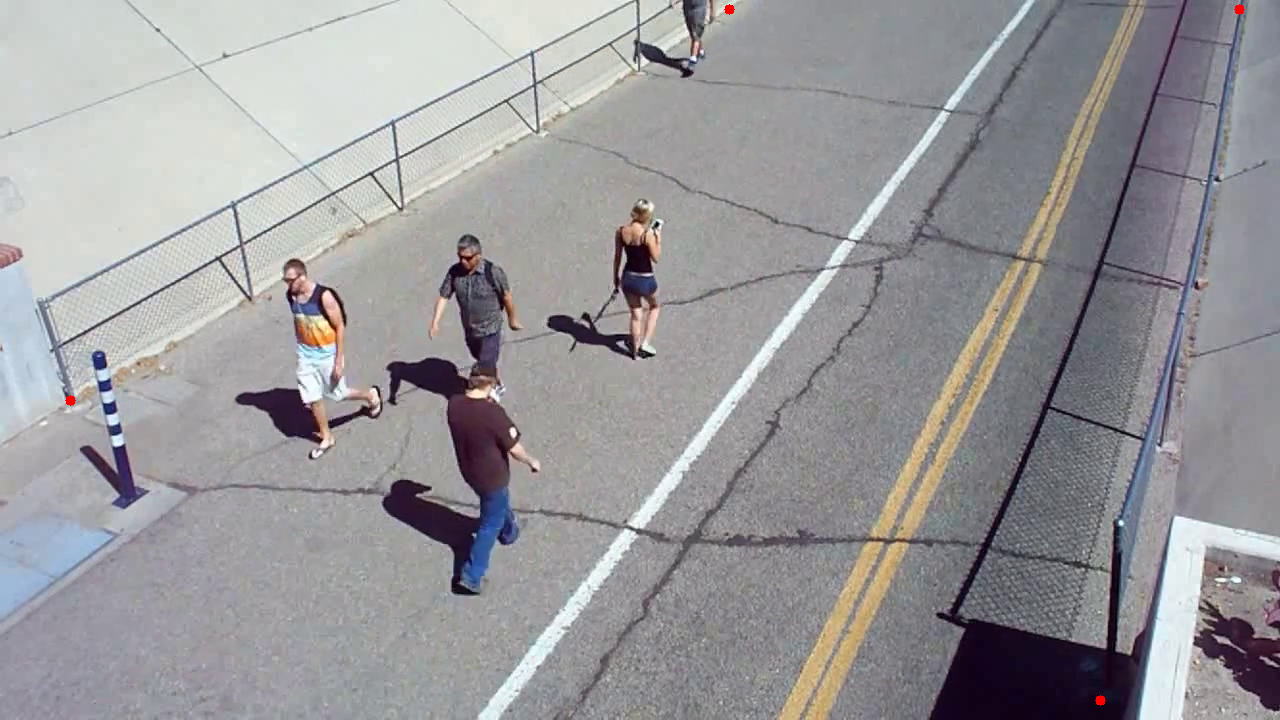

In [8]:
temp = cv2.imread("frames/350.png")
# Pixel position to draw at

r1,c1= 70 , 400
r2,c2= 1100, 700
r3,c3= 1239, 9
r4,c4 = 729, 9

height, width, col = temp.shape

temp=cv2.circle(temp,(r1, c1), 5, (0,0,255), -1)
temp=cv2.circle(temp,(r2, c2), 5, (0,0,255), -1)
temp=cv2.circle(temp,(r3, c3), 5, (0,0,255), -1)
temp=cv2.circle(temp,(r4, c4), 5, (0,0,255), -1)

cv2_imshow(temp)

compute the transformation matrix and the transformed image

In [9]:
def compute_perspective_transform(corner_points,width,height,img):
	# Create an array out of the 4 corner points
	corner_points_array = np.float32(corner_points)
	# Create an array with the parameters (the dimensions) required to build the matrix
	img_params = np.float32([[0,0],[width,0],[0,height],[width,height]])
	# Compute and return the transformation matrix
	matrix = cv2.getPerspectiveTransform(corner_points_array,img_params) 
	img_transformed = cv2.warpPerspective(img,matrix,(width,height))
	return matrix,img_transformed

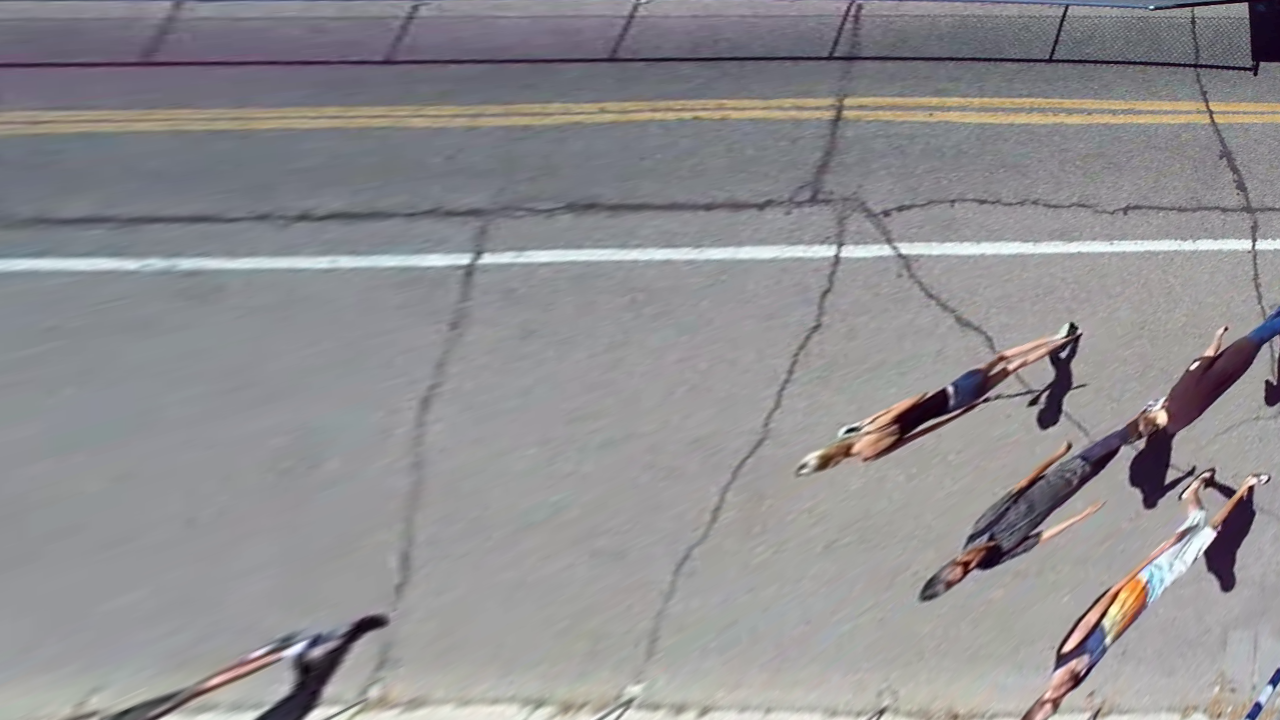

In [10]:
mat,trans_img=compute_perspective_transform(((r3,c3),(r2,c2),(r4,c4),(r1,c1)),width,height,img);
cv2_imshow(trans_img)

use visualizer to draw the predictions on the image.

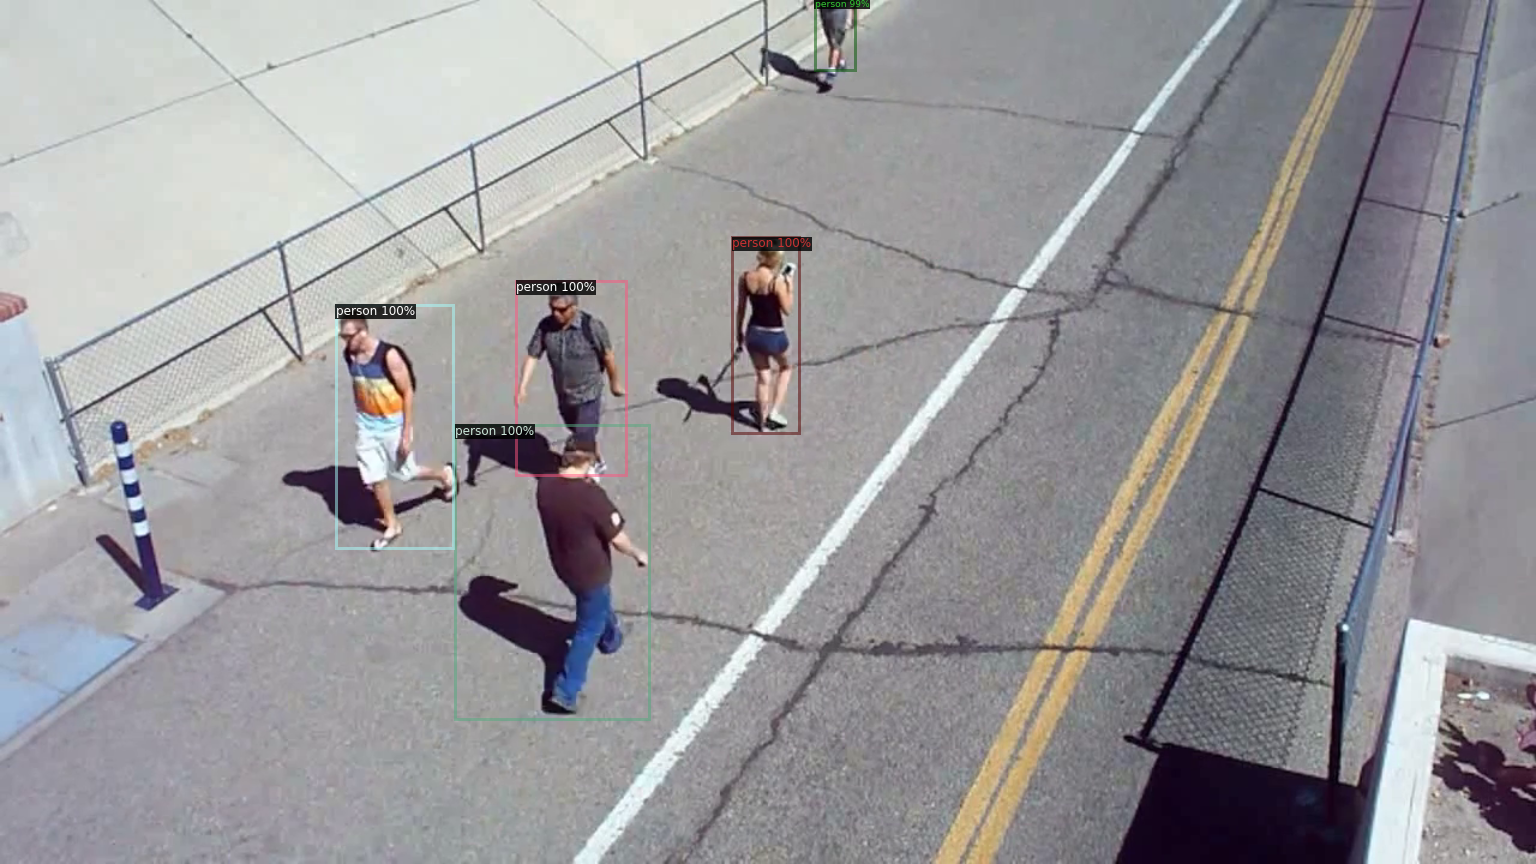

In [11]:
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

get the class and bounding box coordinates for the objects

In [12]:
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[0 0 0 0 0]
[[2.7982281e+02 2.5475398e+02 3.7786600e+02 4.5729803e+02]
 [4.3020764e+02 2.3496858e+02 5.2168250e+02 3.9593655e+02]
 [3.7941690e+02 3.5452118e+02 5.4116461e+02 5.9947675e+02]
 [6.1029279e+02 1.9863881e+02 6.6617090e+02 3.6093015e+02]
 [6.7876221e+02 6.3505554e-01 7.1270081e+02 5.9594971e+01]]


identity only persons (class=0)



In [13]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

#total no. of persons
num= len(person)

In [14]:
x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

279.8228 254.75398 377.866 457.29803


make bounding box

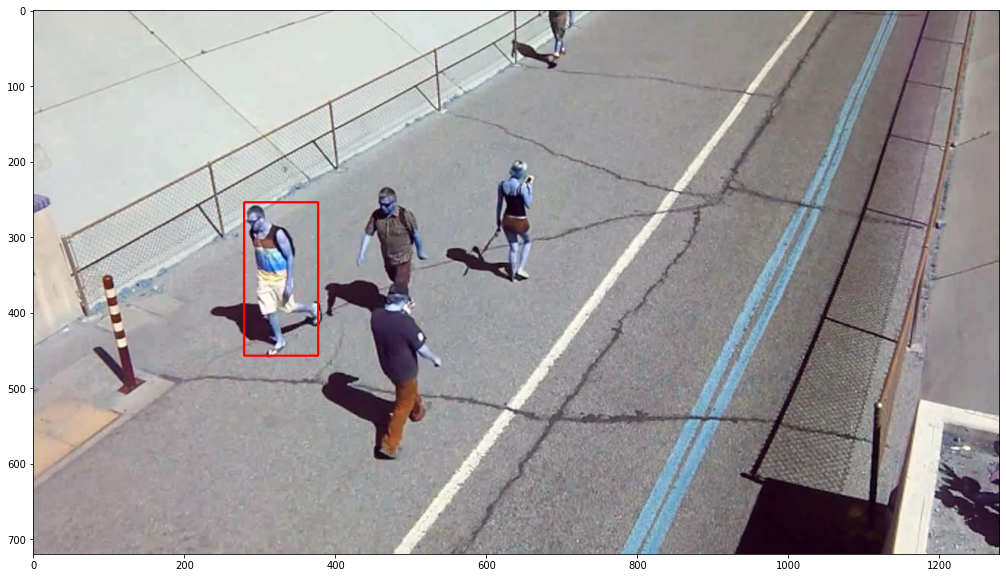

In [15]:
img = cv2.imread('frames/350.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

compute center

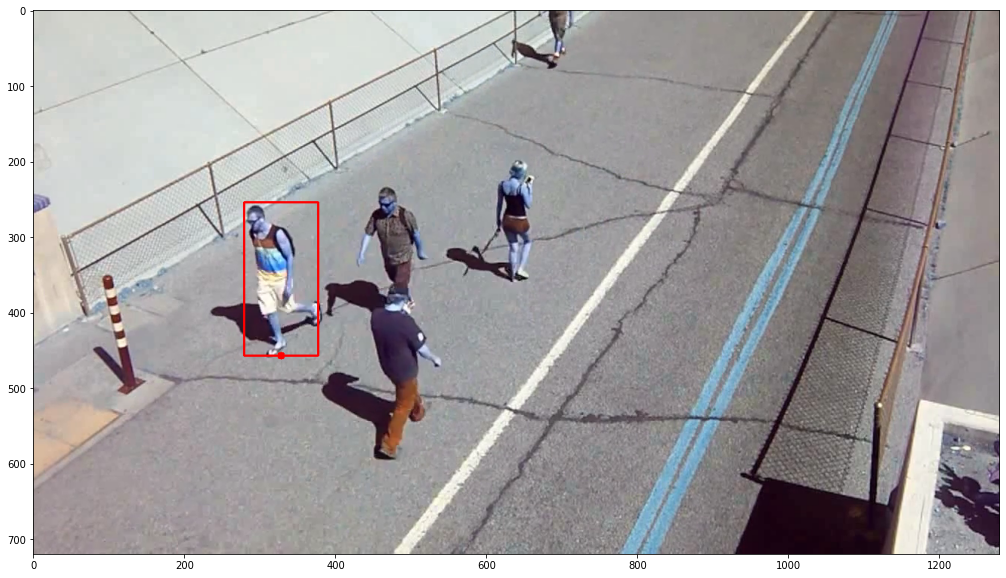

In [16]:
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

define a function which return the bottom center of every bbox

In [17]:
def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (255, 0, 0), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

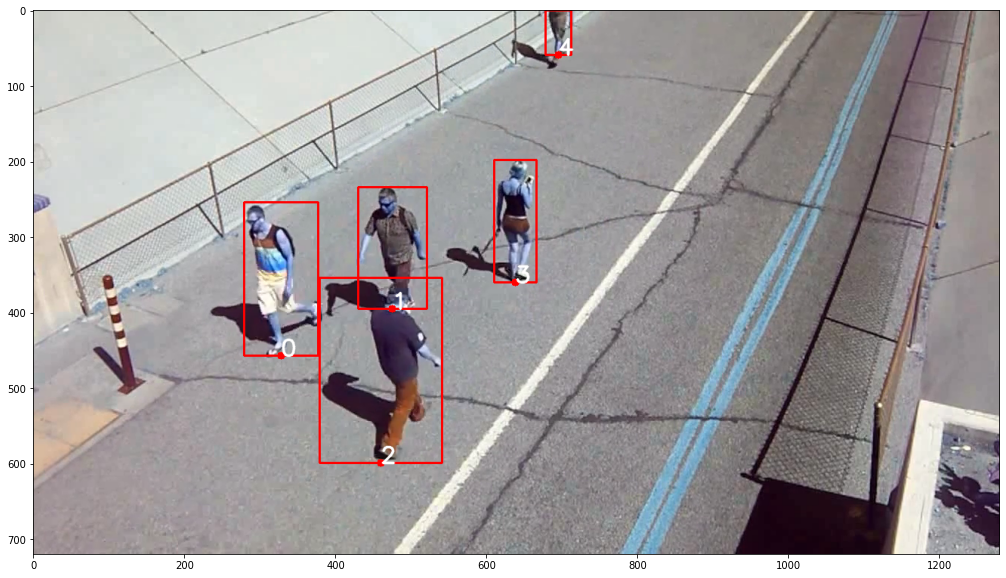

In [18]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]
#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

Apply the perspective transformation to every ground point which have been detected on the main frame.

In [19]:
def compute_point_perspective_transformation(matrix,list_downoids):
	if len(list_downoids) == 0: 
		return (list_downoids)
	
	# Compute the new coordinates of our points
	list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
	transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
	# Loop over the points and add them to the list that will be returned
	transformed_points_list = list()
	for i in range(0,transformed_points.shape[0]):
		transformed_points_list.append([transformed_points[i][0][0],transformed_points[i][0][1]])
	return transformed_points_list

In [20]:
midpoints=compute_point_perspective_transformation(mat,midpoints)

compute the distance bw each person in the frame

In [21]:
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 59.4 ms, sys: 10.5 ms, total: 69.9 ms
Wall time: 156 ms


In [22]:
dist= compute_distance(midpoints,num)
print(dist)

[[   0.          111.9156189   181.56150818  228.53005981  981.06030273]
 [   0.            0.          211.06471252  120.29399872  893.94622803]
 [   0.            0.            0.          260.86437988 1096.4083252 ]
 [   0.            0.            0.            0.          843.25213623]
 [   0.            0.            0.            0.            0.        ]]


find the person violating the threshold to maintain social distancing


In [23]:
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [24]:
import pandas as pd

thresh=120
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

p1  p2        dist
0   0   1  111.915619

make violations to red

In [25]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)  
  return img

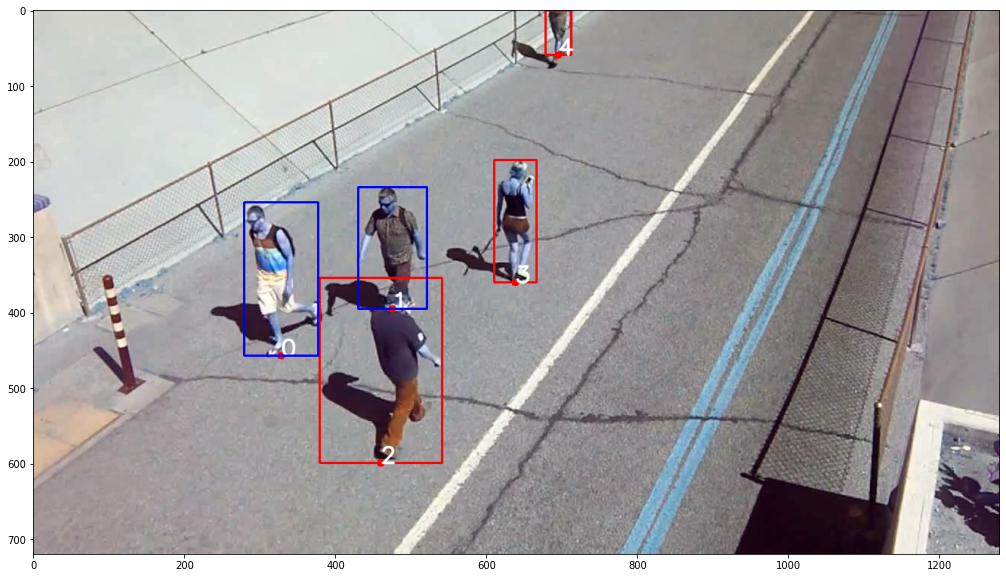

In [26]:
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

# processing the above steps for each frame 

In [27]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

visualizing the movement of people through perspective transform

In [28]:
def movement_vis(h,w,midpoints,num,p1,p2):
  screen=np.ones([h,w,3],dtype=float)*255
  for i in range(num):
    if (i in p1) or (i in p2):
      screen=cv2.circle(screen,(midpoints[i][0],midpoints[i][1]), 8, (0,0,255), -1)
    else:
      screen=cv2.circle(screen,(midpoints[i][0],midpoints[i][1]), 8, (255,0,0), -1)
  return screen;

In [29]:
def find_closest_people(name,thresh):
  img = cv2.imread('frames/'+name)
  height, width, col = img.shape
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  r1,c1= 70 , 400
  r2,c2= 1100, 700
  r3,c3= 1239, 9
  r4,c4 = 729, 9
  mat,trans_img=compute_perspective_transform(((r3,c3),(r2,c2),(r4,c4),(r1,c1)),width,height,img);
  midpoints=compute_point_perspective_transformation(mat,midpoints)
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  pos=movement_vis(height, width,midpoints,num,p1,p2);
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('frames/'+name,img)
  cv2.imwrite('position/'+name,pos);
  return 0

In [30]:
!rm -r position/*
!mkdir position/

from tqdm import tqdm
thresh=120
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

rm: cannot remove 'position/*': No such file or directory


100%|██████████| 732/732 [12:01<00:00,  1.01it/s]


# saving the visualizations 

In [31]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames/'+frames[i])

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 20.6 s, sys: 1.31 s, total: 21.9 s
Wall time: 24.2 s


In [32]:
%%time
position = os.listdir('position/')
position.sort(key=lambda f: int(re.sub('\D', '', f)))

position_array=[]

for i in range(len(position)):
    
    #reading each files
    img = cv2.imread('position/'+position[i])

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    position_array.append(img)

out = cv2.VideoWriter('position_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(position_array)):
    # writing to a image array
    out.write(position_array[i])
out.release()

CPU times: user 9.7 s, sys: 1.02 s, total: 10.7 s
Wall time: 12.3 s
